# THE TRAINING DATA 

In [1]:
import random

In [2]:
file=open("train.ft.txt","r",encoding="utf8")
train_file_lines=[x for x in file]
file.close()

In [3]:
random.sample(train_file_lines,10)

['__label__1 Put them on the street where they belong.: As a parent, I find these dolls too sugestive for younger children. I am by no means a conservative, but these babyz are over the line. I find dolls that dress like Fredericks of Hollywood not suitable for younger girls! If you are a parent, think before you buy these dolls.\n',
 '__label__1 this is weak: i think this was weak exepted the song by mo thugs and layzie bone kuz they are da best im a wasteland warrior a mighty mo thug warrior gotz 2 give it up 2 layzie krayzie bizzy wi$h and my man fle$h cleveland ......... suka\n',
 "__label__2 A rough ride indeed: Kimmage rode with some of the greats of cycling, but was only in the cold shadow of greatness in terms of ability. He details in the book the means taken by some cyclists to climb out of the shadows into the sunshine by taking drugs. His book was brave at the time, he was accused of 'spitting in the soup' and lost the friendship of many of his cycling peers for his writing

# PRE-PROCESSING

IMPORTING LIBRARIES AND DOWNLOADING TOOLKITS

In [4]:
import lxml
import spacy
import nltk
import re
from bs4 import BeautifulSoup          #To remove html tags while preprocessing reviews.

nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('words')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

from spacy.cli.download import download
download(model="en_core_web_sm")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


FUNCTIONS FOR SCREENING STOPWORDS, NON-ENGLISH WORDS AND LEMMATIZING AND FILTERING WORDS WITH LENGTH LESS THAN 3.

In [5]:
def remove_underscores(sentence):                    #removing unnecessary character occurences
    sentence= sentence.replace("_"," ")
    sentence = sentence.replace("\\","")
    return sentence


def remove_extra_words(sentence):                     #removing stop words and meaningless words and occurences
    new_sentence=""
    for w in sentence.split():
        w=w.lower()
        if w in english_words and w not in stop_words and w.isalpha():
            new_sentence=new_sentence+" "+w
    return new_sentence

def lemmatize_and_filter(sentence, min_word_length): #lemmatizing words and lose the ones with length less than equal to min_word_length.
    sent = ""
    for word in sentence.split():
        word=word.lower()
        if len(lemmatizer.lemmatize(word)) > min_word_length:
            sent= sent+" "+lemmatizer.lemmatize(word)
    return(sent)

FUNCTION FOR POSTAG SCREENING

In [6]:

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def postags_screening(texts):
    allowed_postags=['ADJ', 'ADV']
    texts_out = []
    for sent in texts:
        doc=nlp(sent)
        sent=""
        for token in doc:
            if token.lemma_ not in ['-PRON-'] and token.pos_ in allowed_postags:        #lemmatization: keeping only adjectives and adverbs
                sent=sent+" "+str(token.lemma_)
        texts_out.append(sent)
    return texts_out


Now we define two functions:
1. split_label_review
2. preprocessed_data

1.split_label_review: This will help convert the unstructured data to a structured dataset by spliting the label/class from the reviews.
2.preprocessed_data:  This will preprocess the reviews with all the functions defined above.

In [7]:
#re.sub(r'[^\w\s],"",string) to remove punctuations.
#re.sub(r'^https?:\/\/.*[\r\n]*', '', string) to remove urls.
#re.split("__label__[1|2]",string)[1] to get the 2nd element of the split, i.e, the review
#strip() to remove whitespaces
#re.findall("1|2", str(lines))[0] to store the first number encountered in the line of the review as the label of the review.
#BeautifulSoup(string, "lxml").text) to remove html tags


def split_label_review(data):
    #takes in list of raw data and returns list of string sentences and the list of their corresponding labels.
    labels = [int(re.findall("1|2", str(lines))[0]) for lines in data]
    reviews = [re.split("__label__[1|2]",str(lines))[1].strip().lower() for lines in data]
    return(reviews,labels)


def preprocessed_data(data):        #takes in list of raw data and returns list of processed string sentences and the list of their corresponding labels.
    reviews = [remove_extra_words(lemmatize_and_filter(BeautifulSoup(re.sub(r'[^\w\s]|^https?:\/\/.*[\r\n]*|\d+', '', remove_underscores(str(lines)).strip().lower()), "lxml").text,3)) for lines in data]
    reviews = postags_screening(reviews)
    return(reviews)



-------------------------------------------------------------------------------------------------------------------------------

## TENSORFLOW (PREPROCESSING) : TRANSFORMING THE DATA.

In [8]:
train_file_lines=random.sample(train_file_lines,100000)

In [9]:
training_sentences, training_labels =  split_label_review(train_file_lines)
training_sentences=preprocessed_data(training_sentences)

In [10]:
l=[len(training_sentences[i].split()) for i in range(len(training_sentences))]

max(l)

36

In [11]:
"""del train_file_lines"""

'del train_file_lines'

## Fitting tokenizer 

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)

In [14]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)

In [15]:
maxlen = max([len(row) for row in training_sequences])
maxlen

36

In [16]:
training_padded = pad_sequences(training_sequences,maxlen)

In [17]:
del training_sentences,training_sequences

In [18]:
# Need this block to get it to work with TensorFlow 
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)


In [19]:
training_padded.shape

(100000, 36)

In [20]:
training_labels.shape

(100000,)

In [21]:
training_padded

array([[   0,    0,    0, ...,    0,  123,   17],
       [   0,    0,    0, ..., 2072,  156,  780],
       [   0,    0,    0, ...,    0,   43,    2],
       ...,
       [   0,    0,    0, ...,  180,  245,    3],
       [   0,    0,    0, ...,   77,    8,   72],
       [   0,    0,    0, ...,   52,    9,   89]])

# **MODEL TRAINING**

In [22]:
vocab_size = max(list(tokenizer.word_index.values()))+1
vocab_size

11788

## **MODEL1**

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(100000, 94), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(int(vocab_size/100), activation='relu'),
    tf.keras.layers.Dense(int(vocab_size/1000), activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 94)          9400000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 94)                0         
_________________________________________________________________
dense (Dense)                (None, 117)               11115     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1298      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12        
Total params: 9,412,425
Trainable params: 9,412,425
Non-trainable params: 0
_________________________________________________________________


In [24]:
CB=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.025, patience=2, cooldown=0)]
history = model.fit(training_padded, training_labels, epochs=5, validation_split=0.25, verbose=1,callbacks=CB)

Epoch 1/5
2344/2344 [==============================] - 338s 144ms/step - loss: -7.4114 - accuracy: 0.4879 - val_loss: -7.6533 - val_accuracy: 0.4981
Epoch 2/5
2344/2344 [==============================] - 337s 144ms/step - loss: -7.6628 - accuracy: 0.4975 - val_loss: -7.6533 - val_accuracy: 0.4981
Epoch 3/5
2344/2344 [==============================] - 344s 147ms/step - loss: -7.6628 - accuracy: 0.4975 - val_loss: -7.6533 - val_accuracy: 0.4981
Epoch 4/5
2344/2344 [==============================] - 323s 138ms/step - loss: -7.6628 - accuracy: 0.4975 - val_loss: -7.6533 - val_accuracy: 0.4981
Epoch 5/5
2344/2344 [==============================] - 313s 134ms/step - loss: -7.6628 - accuracy: 0.4975 - val_loss: -7.6533 - val_accuracy: 0.4981


## EVALUATION

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def plot_graphs(history, string):
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  

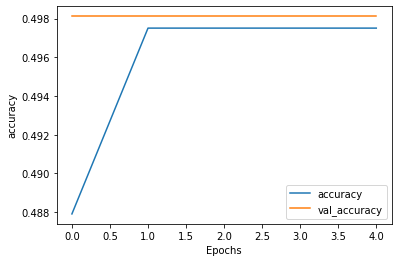

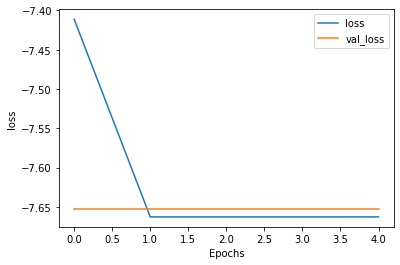

In [27]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


## **MODEL2**

In [28]:
"""model2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(5000, 200),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(500,activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])"""

'model2 = tf.keras.Sequential([\n  tf.keras.layers.Embedding(5000, 200),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(500,activation="tanh"),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(1)])'

In [29]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 200),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])





model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2357600   
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 2,357,801
Trainable params: 2,357,801
Non-trainable params: 0
_________________________________________________________________


In [30]:
CB=[ tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.025, patience=2, cooldown=0)]
history2 = model2.fit(training_padded, training_labels, epochs=5, validation_split=0.25, verbose=1,callbacks=CB)

Epoch 1/5
2344/2344 [==============================] - 83s 35ms/step - loss: -352.0436 - binary_accuracy: 0.4971 - val_loss: -1009.2294 - val_binary_accuracy: 0.4981
Epoch 2/5
2344/2344 [==============================] - 85s 36ms/step - loss: -2128.6458 - binary_accuracy: 0.4975 - val_loss: -3437.6543 - val_binary_accuracy: 0.4981
Epoch 3/5
2344/2344 [==============================] - 91s 39ms/step - loss: -5109.8066 - binary_accuracy: 0.4975 - val_loss: -6942.5391 - val_binary_accuracy: 0.4981
Epoch 4/5
2344/2344 [==============================] - 88s 37ms/step - loss: -9121.7822 - binary_accuracy: 0.4975 - val_loss: -11449.2930 - val_binary_accuracy: 0.4981
Epoch 5/5
2344/2344 [==============================] - 84s 36ms/step - loss: -14123.5527 - binary_accuracy: 0.4975 - val_loss: -16943.3105 - val_binary_accuracy: 0.4981


In [31]:
history2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])

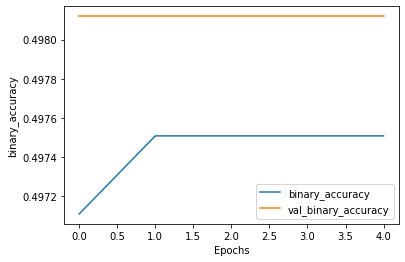

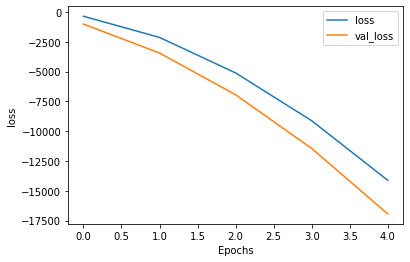

In [32]:
plot_graphs(history2, "binary_accuracy")
plot_graphs(history2, "loss")

## **MODEL3**

In [33]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model3.summary()

CB=[ tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.025, patience=2, cooldown=0)]
history3 = model3.fit(training_padded, training_labels, epochs=5, validation_split=0.25, verbose=1,callbacks=CB)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          589400    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               20400     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 650,001
Trainable params: 650,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2344/2344 [==============================] - 25s 10ms/step - loss: -40.4020 - accuracy: 0.4975 - val_los

In [34]:
history3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

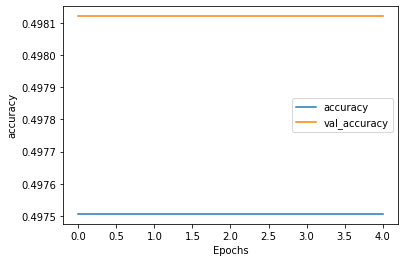

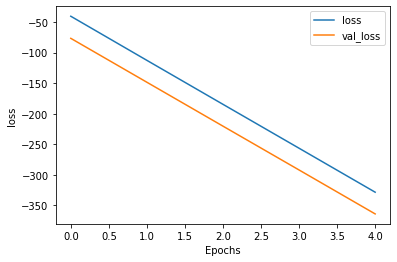

In [35]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")


**CONCLUSION:** None of the model performs to any amount of satisfaction.